# План домашних заданий


- Описание задачи и знакомство с данными
- Домашнее задание 1. Генерация и фильтрация признаков
- Домашнее задание 2. Прогноз времени и вида поломки машин, настройка ML-модели
- Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков
- Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`
- Домашнее задание 4. Блендинг
- Домашнее задание 5. Парсинг внешних данных и оптимизация памяти
- Отправка финального решения на лидерборд на Kaggle

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# <center id="part0"> Описание задачи

**Предыстория:**  мы работаем с каршеринговой компанией, которая управляет крупным автопарком машин. Наша цель — предотвратить длительные периоды простоя машин из-за поломок через своевременное обслуживание и ремонт.


**Идея для решения проблемы:** создать приоритизированный список обхода машин. Этот список поможет технической бригаде сосредоточиться на автомобилях, которые наиболее вероятно выйдут из строя в ближайшее время.


**Как компания решает задачу:**

* Собирает данные о поездках и состоянии машин до поломок.

* Нанимает Data Scientist, чтобы он смог использовать эти данные для анализа и прогнозирования характера поломок.

**Важный момент**: задачи этого специалиста (Data Scientist) предстоит выполнять вам.

## <center> Знакомство с данными

### Информация про машины с таргетом (основной датасет)

In [143]:
car_train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv')
car_train.sample(5)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
1054,F-1617117u,Kia Rio X,economy,petrol,5.86,2012,31246,2018,57.50,engine_ignition
701,C-4073157k,Smart ForTwo,economy,petrol,5.22,2017,112123,2021,26.09,engine_overheat
629,l-1607581F,Smart ForTwo,economy,petrol,3.80,2014,56704,2014,42.58,engine_fuel
749,C50359433E,VW Polo VI,economy,petrol,3.60,2013,37727,2018,26.96,gear_stick
1936,x-8934991u,Smart Coupe,economy,petrol,4.56,2016,90032,2020,34.30,engine_fuel


- `car_id` — идентификатор машины
- `model` / `car_type` / `fuel_type` — марка, класс и тип топлива машины
- `car_rating` / `riders` — общий рейтинг и общее число поездок к концу 2021 года
- `year_to_start` / `year_to_work` — год выпуска машины и год начала работы в автопарке
- `target_reg` — количество дней до поломки
- `target_class` — класс поломки (всего 9 видов)

### Информация про поездки

In [144]:
rides_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv')
rides_info.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
677849,x16962120R,v22254568R,l1C,2020-03-04,4.87,41,651,45,101.043056,1,1801.232544,0,-1.615658,-6.702
82705,t12155099e,F93749838u,h1D,2020-01-30,3.84,36,427,41,134.000000,2,1310.799486,0,-9.163753,-8.096
59040,N13818407h,E-1556800P,c1q,2020-01-29,6.93,43,641,30,46.000000,3,645.282998,0,-0.900805,0.000
52892,b89478547D,D11776354f,a1k,2020-03-31,5.08,150,1344,35,49.438726,1,1121.413778,0,3.386754,10.333
135946,H13541727s,J16760665u,J1U,2020-01-28,2.45,37,328,30,47.000000,1,1156.205374,0,-0.684797,-9.684


- `user_id` / `car_id` / `ride_id` — идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` — дата поездки и рейтинг, поставленный водителем
- `ride_duration` / `distance` / `ride_cost` —  длительность (время),  пройденное расстояние, стоимость поездки
- `speed_avg` / `speed_max` — средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` — количество остановок (паузы) и флаг: была ли дозаправка
- `user_ride_quality` — оценка манеры вождения водителя машины, определенная скоринговой ML-системой сервиса
- `deviation_normal` — общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы)

### Информация про водителей

In [145]:
driver_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv')
driver_info.sample(5)

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
4144,44,6.9,1040,10.0,L10913339f,0,2019-2-15
1955,53,7.1,519,NaN,H15742627r,0,2020-6-26
781,35,7.9,979,1.0,u20048000t,0,2019-2-29
5034,23,9.1,85,15.0,U22047075b,1,2020-1-19
3468,38,7.4,813,4.0,g22893690y,0,2019-4-14


- `user_id` / `age` / `sex` — идентификатор, возраст и пол водителя, соответственно
- `user_rating` — общий рейтинг пользователя за все поездки к концу 2021 года
- `user_rides` — общее количество поездок к концу 2021 года
- `user_time_accident` — число инцидентов (это могли быть аварии/штрафы/эвакуация машины)  
- `first_ride_date` — дата первой поездки

### Информация про ремонт машин

In [146]:
fix_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv')
fix_info.sample(5)

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
4845,y-1918667p,CB,2019-3-22 20:33,repair,5.7,19
59880,C-4941408C,FD,2020-11-14 1:28,reparking,1.0,17
104733,m41491349u,RD,2019-11-25 17:42,refuel_check,1.0,29
63489,D-4712260c,QX,2020-8-23 3:31,reparking,1.0,22
47669,s-1243339h,TM,2019-2-12 14:23,reparking,1.0,34


- `worker_id` / `car_id` — идентификатор работника и машины
- `work_type` / `work_duration` — тип и длительность (в часах) проводимой работы
- `destroy_degree` — степень износа/поврежденности машины в случае поломки
- `fix_date` — время начала ремонта (снятия машины с линии)

# Домашнее задание 1. Генерация и фильтрация признаков

<center> <img src="https://ucarecdn.com/bf4c772d-b67a-42ae-a48b-cfd83910b0a2/" width=700>

<div class="alert alert-info">

**Цель блока** — сгенерировать признаки из дополнительных датасетов и добавить их к основному датасету, произвести фильтрацию признаков.

    
## Задание 1. Генерация признаков из дополнительных датасетов (6 баллов)

<div class="alert alert-info">

1. Возьмите датасет `rides_info` с информацией о поездках и проведите группировку по каждой машине отдельно.

2. Для каждой машины (то есть для каждого `car_id`) подсчитайте несколько признаков:
  - минимальный рейтинг за все поездки;
  - средний рейтинг за все поездки;
  - общее количество километров, которое машина проехала;
  - максимальная скорость;
  - общее количество поездок для каждой машины.

3. Добавьте минимум 3 признака на свой выбор.

4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

5. Подключите информацию про водителей (`driver_info`) и про ремонт машин (`fix_info`). Добавьте минимум 3 любых признака с каждого датасета.


<h4> Критерии оценивания </h4>
    
- Добавлены 5 обязательных и минимум 3 любых признака из датасета `rides_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `driver_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `fix_info` — 2 балла.

</div>

<div class="alert alert-success">
    
<h4> Советы по Feature Engineering</h4>
    
- Начинайте с сырых данных.
- Используйте все доступные данные. Покрывайте признаками всю имеющуюся информацию в данных.
- Формулируйте предположения: от чего зависит таргет?
- Смотрите визуально на классы/ошибки и делайте предположения. Какие полезны?
- Помните, что слишком много признаков может быть вредно. Потом придется отфильтровывать.
    
<h4> Полезные источники </h4>
    
- Занятие про Feature Engineering.
- Занятие про Feature Selection.
- [Max Kuhn and Kjell Johnson. Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/).

### Пример расчета признака

In [147]:
fix_info

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
0,P17494612l,RJ,2020-6-20 2:14,reparking,8.0,49
1,N-1530212S,LM,2020-2-9 20:25,repair,10.0,48
2,B-1154399t,ND,2019-8-24 7:1,reparking,1.0,27
3,y13744087j,PG,2019-8-10 9:29,reparking,1.0,28
4,F12725233R,YC,2020-11-12 5:22,refuel_check,8.0,47
...,...,...,...,...,...,...
145995,j92079780S,NG,2019-1-21 14:34,reparking,1.0,36
145996,N89944460U,WM,2019-4-30 11:33,repair,2.6,13
145997,f63189062N,NY,2019-3-7 20:49,repair,5.0,14
145998,j-1712772o,IP,2018-2-18 19:10,repair,5.0,13


In [148]:
rides_users = rides_info.merge(driver_info, on='user_id')

In [149]:
# Пример расчета одного признака
rides_grouped = rides_users.groupby('car_id', as_index=False).agg(
    mean_rating = ('rating', 'mean'),
    min_rating = ('rating', 'min'),
    mean_ride_duration = ('ride_duration', 'mean'),
    ride_qty = ('ride_id', 'count'),
    mean_user_ride_quality = ('user_ride_quality', 'mean'),
    total_distance = ('distance', 'sum'),
    mean_deviation = ('deviation_normal', 'mean'),
    revenue = ('ride_cost', 'sum'),
    avg_check = ('ride_cost', 'mean'),
    avg_speed = ('speed_avg', 'mean'),
    max_speed = ('speed_max', 'mean'),
    mean_user_rating = ('user_rating', 'mean'),
    avg_sex = ('sex', 'mean'),
    avg_user_age = ('age', 'mean'),
)

fixes = fix_info.groupby('car_id', as_index=False).agg(
    total_fixes = ('car_id', 'count'),
    total_fix_duration = ('work_duration', 'sum'),
    last_fix_date = ('fix_date', 'max'),
)
add_features = rides_grouped.merge(fixes, on='car_id')


df = pd.merge(car_train, add_features, on='car_id') 

df.head()


,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,revenue,avg_check,avg_speed,max_speed,mean_user_rating,avg_sex,avg_user_age,total_fixes,total_fix_duration,last_fix_date
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,3498596,20106.873563,44.660920,87.183965,8.229885,0.505747,33.511494,35,933,2021-12-1 11:33
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,...,4665569,26813.614943,49.862069,89.474427,7.988506,0.419540,34.988506,35,873,2021-6-1 13:9
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,...,4173876,23987.793103,44.005747,67.473599,7.843103,0.551724,32.839080,35,915,2021-9-13 7:30
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,...,6584001,37839.086207,49.344828,86.661339,8.524138,0.442529,34.977011,35,1007,2021-9-20 15:46
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,...,3460587,19888.431034,50.603448,86.263698,8.112069,0.465517,34.298851,35,981,2021-3-26 8:50


### Идеи для новых признаков

1.   Новый пункт
2.   Новый пункт



* `feature_min_max_diff` — разница между максимальным и минимальным значениями `deviation_normal` для каждой машины
* `feature_corner` — угол наклона по признаку `user_ride_quality` для каждой машины
* `feature_mean` — среднее значение `deviation_normal` для каждой машины
* `feature_shift` — точка перегиба/сдвига для `deviation_normal`
* `feature_start` — значение точки старта для `deviation_normal`
* `feature_nans` — сумма пропусков для столбца `...` для каждой машины
* `feature_quant` — `X %` квантиль для столбца `...` для каждой машины

Подумайте, какие из признаков могут оказаться самыми полезными?

In [150]:
# YOUR CODE HERE

## Задание 2. Применение методов фильтрации признаков (4 балла)

<center> <img src="https://ucarecdn.com/d1b4bc78-fd04-44fb-bdbf-0a63355b7384/" width=700>

1. Выберите и примените любые 3 (можно и больше) метода фильтрации, которые указаны выше или в ноутбуке по фильтрации из полезных ссылок.
2. Проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- Применены методы фильтрации — 1 балл за каждый метод, максимум 3 балла.
- Сделаны выводы на основе примененных методов —1 балл.
</div>

### Советы по Feature Selection

<div class="alert alert-info">

<h3><center>Зачем отбирать признаки</center></h3>
    
**Основные причины**:
    
- Главная причина: с увеличением количества признаков часто падает точность предсказания модели, а некоторые модели и вовсе перестают адекватно работать. Так происходит, если в данных большое количество мусорных фичей (почти не коррелирующих с таргетом).

- Если фичей очень много, то данные перестают помещаться в память и существенно увеличивают время обучения модели, особенно если мы тестируем несколько алгоритмов или ансамбль. Также важно учитывать, что платформы имеют ограничения на длительность одной сессии (в Kaggle — 12 часов) и лимиты по потребляемой памяти.

- Даже если точность не снижается, есть риск, что модель опирается на шумные фичи, что снизит стабильность прогноза на приватной выборке.


<b>Что удалить сразу:</b>
    
- константы;
- уникальные значения (в том числе в тесте; как правило, это ID-шники по типу `car_id`).
    
<b>Какие методы использовать:</b>
    
- `Линейная корреляция`.
- `Phik` — тоже корреляция, но на стероидах ([туториал на Medium](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)).
- `Permutation importance` (из `scikit-learn`).
- `SHAP values` (из библиотеки `shap`).
- `CatBoost Feature Selection` (рекурсивные методы).
    

In [151]:
df.describe()

,car_rating,year_to_start,riders,year_to_work,target_reg,mean_rating,min_rating,mean_ride_duration,ride_qty,mean_user_ride_quality,...,mean_deviation,revenue,avg_check,avg_speed,max_speed,mean_user_rating,avg_sex,avg_user_age,total_fixes,total_fix_duration
count,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000,2337.0,2337.000000,...,2337.000000,2.337000e+03,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000
mean,4.354292,2014.040650,63711.443731,2018.069748,44.946735,4.478831,0.138870,1663.627679,174.0,-0.173748,...,-1.532298,3.627590e+06,20848.220715,46.987967,83.783434,8.024367,0.474742,34.111952,34.356012,896.765939
std,0.996954,1.685852,33755.012096,2.159484,17.579568,0.418588,0.163978,489.857337,0.0,8.966969,...,14.795166,1.412296e+06,8116.641364,2.761202,11.299347,0.173792,0.052298,1.039410,0.478921,76.256346
min,0.980000,2011.000000,23.000000,2014.000000,18.920000,3.529885,0.000000,221.689655,174.0,-36.143281,...,-67.437615,4.006630e+05,2302.660920,42.436782,64.144588,7.677011,0.293103,31.109195,34.000000,649.000000
25%,3.740000,2013.000000,41053.000000,2016.000000,31.670000,4.155747,0.100000,1318.454023,174.0,-5.762302,...,-7.543184,2.713455e+06,15594.568966,44.511494,73.992927,7.931609,0.436782,33.396552,34.000000,845.000000
50%,4.360000,2014.000000,64415.000000,2018.000000,40.170000,4.442989,0.100000,1634.402299,174.0,-0.659841,...,-2.293339,3.412835e+06,19613.994253,45.689655,86.132087,8.031034,0.477011,34.028736,34.000000,897.000000
75%,5.000000,2015.000000,86515.000000,2020.000000,54.790000,4.675345,0.100000,1971.103448,174.0,5.534738,...,6.332126,4.205896e+06,24171.816092,49.666667,93.139549,8.101724,0.511494,34.770115,35.000000,945.000000
max,8.900000,2017.000000,142862.000000,2022.000000,141.630000,5.700747,1.500000,3633.712644,174.0,33.885249,...,66.415126,1.336334e+07,76800.833333,53.132184,106.811364,9.271264,0.626437,37.873563,35.000000,1203.000000


In [152]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
import shap



constant_features = ["ride_qty"]
unique_features = ["car_id"]
unused_features = set(constant_features + unique_features)


df.drop(unused_features, axis=1, inplace=True)


df_numeric_features = df[df.describe().columns]
target = df['target_reg']




In [153]:
correlation_matrix = df_numeric_features.corrwith(target)
print("Корреляция линейная с целевой переменной:")
correlation_matrix.sort_values(ascending=False).head(50)

Корреляция линейная с целевой переменной:


target_reg                1.000000
max_speed                 0.391430
mean_user_rating          0.332570
mean_deviation            0.134768
revenue                   0.075637
avg_check                 0.075637
avg_user_age              0.063658
min_rating                0.038629
year_to_work              0.034604
mean_user_ride_quality    0.033530
car_rating                0.024515
total_fixes               0.008964
year_to_start             0.006390
riders                    0.003259
avg_sex                  -0.012075
mean_rating              -0.017549
mean_ride_duration       -0.036293
total_distance           -0.073692
avg_speed                -0.112508
total_fix_duration       -0.123805
dtype: float64

In [154]:
regressor = RandomForestRegressor(random_state=42)
regressor.fit(df_numeric_features, target)
feature_importance = pd.Series(regressor.feature_importances_, index=df_numeric_features.columns).sort_values(ascending=False)
print("Метод перестановок:")
feature_importance.head(50)

Метод перестановок:


target_reg                0.999506
mean_rating               0.000057
mean_user_ride_quality    0.000054
avg_check                 0.000040
revenue                   0.000038
year_to_start             0.000036
riders                    0.000033
mean_deviation            0.000031
mean_user_rating          0.000031
total_distance            0.000028
total_fix_duration        0.000026
year_to_work              0.000021
max_speed                 0.000020
avg_user_age              0.000019
avg_speed                 0.000016
mean_ride_duration        0.000015
car_rating                0.000012
avg_sex                   0.000010
min_rating                0.000005
total_fixes               0.000001
dtype: float64

In [155]:
shap_explainer = shap.TreeExplainer(regressor)
shap_scores = shap_explainer.shap_values(df_numeric_features)


feature_importance_shap = np.abs(shap_scores).mean(axis=0)
feature_importance_shap = pd.Series(feature_importance_shap, index=df_numeric_features.columns).sort_values(ascending=False)

print("SHAP:")
feature_importance_shap

SHAP:


target_reg                13.798323
mean_user_ride_quality     0.002206
avg_check                  0.001853
revenue                    0.001843
mean_deviation             0.001689
avg_sex                    0.001629
mean_rating                0.001581
total_fix_duration         0.001503
mean_user_rating           0.001499
total_distance             0.001415
riders                     0.001403
avg_speed                  0.001400
max_speed                  0.001282
year_to_work               0.001249
car_rating                 0.001222
mean_ride_duration         0.001124
year_to_start              0.001097
avg_user_age               0.001051
min_rating                 0.000559
total_fixes                0.000415
dtype: float64

Результаты:

Линейная корреляция лучше всего показала зависимость (линейную) признаков от таргета. К признакам, демонстрирующим наибольшую линейную зависимость можно отнести - максимальную скорость, средний рейтинг пользователя,  средние значения показателя датчиков о состоянии машины


# Домашнее задание 2. Прогноз времени и вида поломки машин. Настройка ML-модели

<div class="alert alert-info">

**Цель блока** — составить тренировочную и валидационную выборки, произвести обучение модели `CatBoostClassifier` на тренировочной части и оценить качество на валидационной.

##Обучение первой модели (5 баллов)

1.   Новый пункт
2.   Новый пункт



1. Классифицируйте признаки на типы (категориальные, числовые, таргеты).

2. Выделите в `X` только признаки, а в `Y` — таргет (для задачи классификации).

3. Сделайте разделение данных на *обучающую* и *валидационную* выборки (не забывайте про воспроизводимость результатов).

4. Создайте и обучите `CatBoostClassifier` модель (настраивать гиперпараметры сейчас не обязательно).

5. Проведите оценку вашей модели, используя метрику `accuracy`.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.

</div>

In [156]:
df.head()

,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,...,revenue,avg_check,avg_speed,max_speed,mean_user_rating,avg_sex,avg_user_age,total_fixes,total_fix_duration,last_fix_date
0,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,4.737759,...,3498596,20106.873563,44.660920,87.183965,8.229885,0.505747,33.511494,35,933,2021-12-1 11:33
1,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,4.480517,...,4665569,26813.614943,49.862069,89.474427,7.988506,0.419540,34.988506,35,873,2021-6-1 13:9
2,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,4.768391,...,4173876,23987.793103,44.005747,67.473599,7.843103,0.551724,32.839080,35,915,2021-9-13 7:30
3,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,3.880920,...,6584001,37839.086207,49.344828,86.661339,8.524138,0.442529,34.977011,35,1007,2021-9-20 15:46
4,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,4.181149,...,3460587,19888.431034,50.603448,86.263698,8.112069,0.465517,34.298851,35,981,2021-3-26 8:50


In [157]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [167]:
features2drop = [''] # то, что надо выбросить
targets = ['target_reg', 'target_class'] # таргеты
target_column = df['target_class']
df_wo_targets = df.drop(targets, axis=1, errors='ignore')
cat_features = list(df_wo_targets.describe(include='O').columns) # категориальные признаки

num_features = list(df_wo_targets.describe().columns) # числовые признаки

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)
print('Целевые переменные', targets)

Категориальные признаки: 4 ['model', 'car_type', 'fuel_type', 'last_fix_date']
Числовые признаки: 19 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'mean_rating', 'min_rating', 'mean_ride_duration', 'mean_user_ride_quality', 'total_distance', 'mean_deviation', 'revenue', 'avg_check', 'avg_speed', 'max_speed', 'mean_user_rating', 'avg_sex', 'avg_user_age', 'total_fixes', 'total_fix_duration']
Целевые переменные ['target_reg', 'target_class']


In [168]:
# YOUR CODE HERE


# Разбиваем данные на обучающую и тестовую выборки
train_features, test_features, train_target, test_target = train_test_split(df_wo_targets, target_column, test_size=0.2)

# Создаем классификатор CatBoost
catboost_model = CatBoostClassifier(cat_features=cat_features)

# Обучаем модель
catboost_model.fit(train_features, train_target,
          eval_set=(test_features, test_target),
          verbose=150, plot=False)

# Инференс
predicted_target = catboost_model.predict(test_features)
print(f'\n Точность: {accuracy_score(test_target, predicted_target)}')

Learning rate set to 0.109335
0:	learn: 1.6946741	test: 1.6860471	best: 1.6860471 (0)	total: 113ms	remaining: 1m 52s
150:	learn: 0.0704237	test: 0.1300449	best: 0.1300449 (150)	total: 29.4s	remaining: 2m 45s
300:	learn: 0.0395261	test: 0.1163792	best: 0.1159732 (292)	total: 43.9s	remaining: 1m 41s
450:	learn: 0.0248731	test: 0.1110008	best: 0.1110008 (450)	total: 58.9s	remaining: 1m 11s
600:	learn: 0.0181358	test: 0.1080485	best: 0.1080485 (600)	total: 1m 13s	remaining: 48.7s
750:	learn: 0.0134128	test: 0.1051518	best: 0.1051003 (741)	total: 1m 28s	remaining: 29.3s
900:	learn: 0.0105930	test: 0.1046432	best: 0.1040003 (860)	total: 1m 42s	remaining: 11.3s
999:	learn: 0.0092033	test: 0.1052499	best: 0.1040003 (860)	total: 1m 52s	remaining: 0us

bestTest = 0.1040003037
bestIteration = 860

Shrink model to first 861 iterations.

 Точность: 0.9572649572649573


# Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков

<div class="alert alert-info">

**Цель блока** — визуализировать результаты прогнозирования, ошибки модели и важность признаков для лучшего понимания и анализа модели.

## Визуализация (5 баллов)

   
1. Визуализируйте важность признаков встроенным методом в `CatBoost`  (помните, что не стоит сильно доверять этому рейтингу важности, т. к. для сильно скоррелированных признаков важность делится пополам — оба признака могут улететь вниз).

2. Постройте `waterfall_plot` из библиотеки `SHAP` (подробнее во втором ноутбуке из полезных ссылок ниже).
    
3. Постройте `classification_report` из библиотеки `scikit-learn`.

4. Постройте и визуализируйте матрицу смежности (`confusion_matrix`), посмотрите, в каких классах модель больше всего ошибается.
    
5. Для каждого графика/примененного метода проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.
    
</div>

<div class="alert alert-success">

Визуализация может помочь даже после того, как мы **уже обучили** какую-нибудь модель. Например:

- Понять, что мешает модели или чего не хватает, чтобы не допускать ошибки.
- Сделать выводы, как можно улучшить точность в последующих экспериментах.
- Визуализировать ошибки модели.
- Отсеять лишние признаки.
- Найти идеи для новых признаков.
- Все зависит от типа ваших данных.

<h3> Полезные источники </h3>
    
- Занятие про визуализацию и Seaborn.
- Занятие про продвинутую визуализацию и анализ ошибок модели.

</div>    

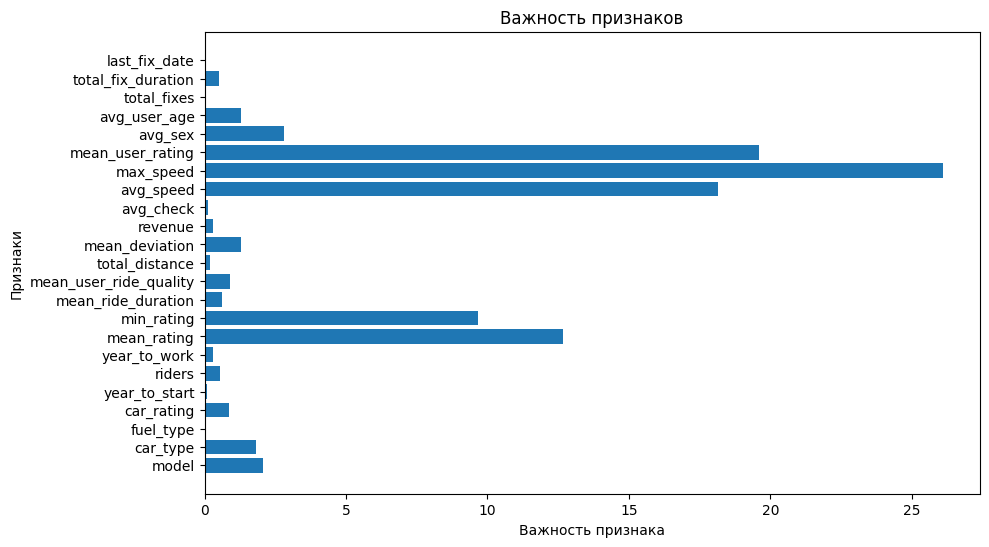

In [169]:
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


importances = catboost_model.feature_importances_

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(range(len(train_features.columns)), train_features.columns)
plt.xlabel('Важность признака')
plt.ylabel('Признаки')
plt.title('Важность признаков')
plt.show()


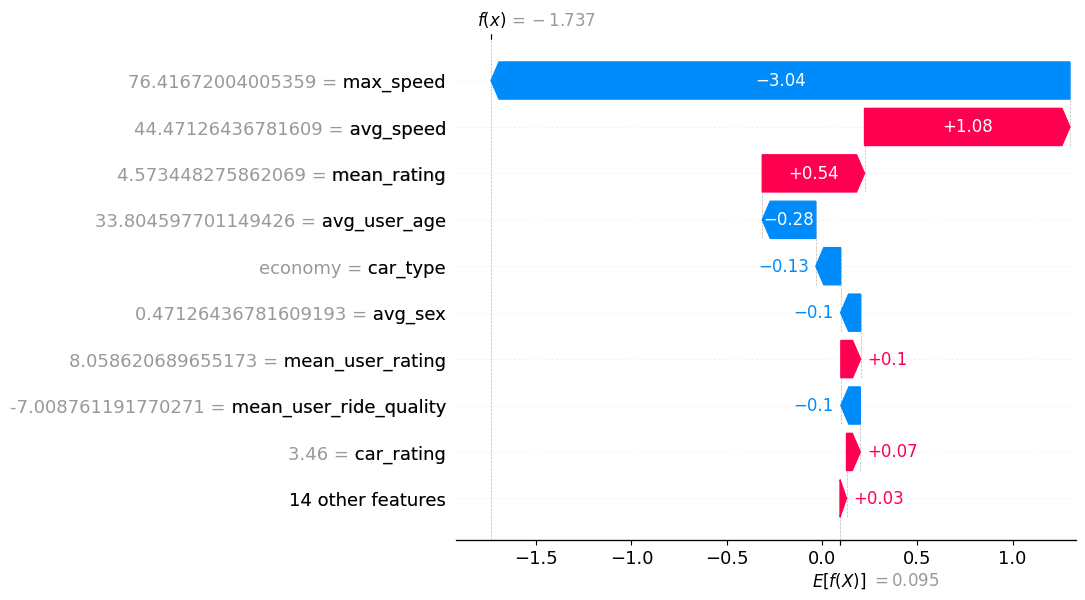

In [170]:
# Использование SHAP для интерпретации модели
explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer(test_features)
shap.plots.waterfall(shap_values[0][:,0])


                 precision    recall  f1-score   support

    another_bug       0.97      0.95      0.96        59
      break_bug       0.98      1.00      0.99        54
    electro_bug       1.00      1.00      1.00        56
   engine_check       0.81      0.83      0.82        42
    engine_fuel       0.98      0.96      0.97        54
engine_ignition       0.92      0.98      0.95        50
engine_overheat       1.00      0.96      0.98        50
     gear_stick       1.00      1.00      1.00        68
    wheel_shake       0.88      0.86      0.87        35

       accuracy                           0.96       468
      macro avg       0.95      0.95      0.95       468
   weighted avg       0.96      0.96      0.96       468


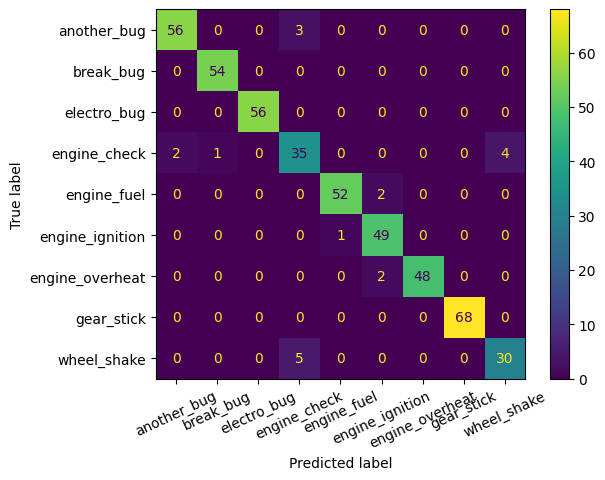

In [171]:
# Вывод отчета о классификации
predicted = catboost_model.predict(test_features)
report = classification_report(y_true=test_target, y_pred=predicted, target_names=catboost_model.classes_)
print(report)

# Вывод матрицы ошибок
ConfusionMatrixDisplay.from_estimator(catboost_model, test_features, test_target, display_labels=catboost_model.classes_, xticks_rotation=25)

# Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, произведя подбор гиперпараметров для модели с помощью `Optuna`.

## Подбор гиперпараметров (3 балла)

1. Напишите `objective` функцию и запустите `Optuna`.
2. Подберите гиперпараметры для `CatBoostClassifier` (минимум 3).
3. Обучите модель с новыми гиперпараметрами, сравните качество и сделайте выводы.

    
<h4> Критерии оценивания </h4>
    
- 1 балл за каждый корректно выполненный пункт.
    
</div>

In [163]:
# YOUR CODE HERE

### Общая информация по `Optuna`

#### Ключевые особенности <code>Optuna</code>



- Легковесность и универсальность — можно подбирать оптимальные параметры под любые функции и метрики.
- SOTA-алгоритмы, адаптированные для поиска гиперпараметров.
- Параллелизация и различные методы прунинга.
- Встроенная визуализация.
- Интеграция со множеством популярных библиотек (бустинги, sklearn, PyTorch, W&B и другие).

Разберем Optuna по частям, чтобы понять, как ее использовать.

#### <code>Study</code>: оптимизация, базирующаяся на <code>Objective</code> функции



В `Objective`-функцию нужно написать код подсчета метрики, которую возвращаем. `Objective` вызывается Optuna много раз для подбора лучших параметров.
```python
def objective(trial, ...):
    # calculate score...
    return score
```

<h4> <code>Trial</code> — одно выполнение <code>Objective</code>-функции</h4>

В `trial`-объекте мы передаем параметры для «перебора», используя для каждого типа свой метод. Например:

```python
# метод `suggest_float` показывает, что перебираем `float` значения, от 0 и до 1.5 границы
param = trial.suggest_float('param', 0, 1.5)

# Категориальное значение
loss_function = trial.suggest_categorical('loss', ['Logloss', 'CrossEntropy'])

# Целочисленное значение
depth = trial.suggest_int('depth', 5, 8)

# Равномерное распределение
learning_rate = trial.suggest_uniform('learning_rate', 0.0, 1.0)
```

#### `Study` parameters

Инициализируем объект `study`, который начнет перебор и сохранит в себе историю результатов.
Если мы стараемся увеличить метрику, а не уменьшить ошибку, то используем `create_study(direction='maximize')`.
```python
study = optuna.create_study()
study.optimize(objective, n_trials=10)
```

<div class="alert alert-info">
    
В [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html) реализовано несколько методов (`sampler`) подбора параметров (в том числе классические):
* `GridSampler`
* `RandomSampler`
* `Tree-Structed Parzen Estimator` (`TPESampler` — самый популярный, дефолтный)
* `BruteForceSampler`
* [Другие 4 метода](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html#module-optuna.samplers) (можно написать собственный семплер)

### Советы по перебору параметров

- Иметь понимание важности параметров.
- Число `iterations` лучше взять с запасом и зафиксировать, при этом ограничив через `early_stopping_rounds`.
- Подсмотреть или чувствовать диапазоны и шаг значений.
- Исключить то, что перебирать не нужно (`random_seed` , `eval_metric`, `thread_count` и прочее).
- Используйте информацию с прошлых попыток.

# Домашнее задание 4. Блендинг

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, объединив несколько моделей вместе методом блендинга.

## Задание 6. Блендинг (10 баллов)

1. Построить и обучить модели:
    - `CatBoostClassifier`,
    - `LightGBMClassifier (goss)`,
    - `XGBoostClassifier (dart)`,
    - `RandomForestClassifier`.
2. Сделать предсказания каждой моделью, оценить качество.
3. Реализовать блендинг двумя способами, оценить качество и сравнить с предыдущим пунктом:
    - `Hard Voting` —  метод, при котором делаем голосование всех моделей и выбираем самый популярный класс.
    - `Soft Voting` —  метод, при котором мы складываем вероятности предсказания всех моделей по каждому классу и потом выбираем самый класс с максимальной суммой.
    
<h4> Критерии оценивания </h4>
    
- Обучены 4 модели — 1 балл за каждую обученную модель, всего 4 балла.
- Для модели проведен подбор гиперпараметров — 0,5 балла за каждый параметр, всего 2 балла.
- Сделаны предсказания каждой модели и оценено качество — 1 балл.
- Реализован `Hard Voting` — 1 балл.
- Реализован `Soft Voting` — 1 балл.
- Сделаны выводы — 1 балл.
    
</div>

In [164]:
# YOUR CODE HERE

### Общая информация о блендинге

**Основная идея** — взять от каждого алгоритма лучшее и совместить несколько разных ML-моделей в одну.

Что это дает:
- Увеличивается обобщающая способность финальной модели и качество улучшается.
- Модель становится более стабильной, что позволяет не слететь на приватном лидерборде.

Особенно хорошо накидывает блендинг, если смешиваемые модели имеют разную природу — например, нейронные сети, kNN и решающие деревья. Они выучивают разные зависимости и хорошо дополняют друг друга.

</div>

# <center id="part6"> Отправка финального решения на лидерборд на Kaggle

<div class="alert alert-info">

**Цель блока** — сделать предсказание с помощью блендинга для тестовой части датасета, отправить результат [в соревнование на Kaggle](https://www.kaggle.com/competitions/competative-data-science-course-by-data-feeling/overview).

## Задание 8. Предсказание на тестовом датасете и отправка на Kaggle

1. Сделать предобработку для тестового датасета, присоединить к нему информацию из других датасетов и добавить признаки, которые генерировали для тренировочного датасета.
2. Сделать предсказания каждой моделью, которую хотите включить в ансамбль, но минимум их должно быть 3.
3. Сделать блендинг с помощью `Hard Voting` или `Soft Voting` на ваш выбор.
4. Сохранить результат предсказания в `csv` файл и отправить решение на Kaggle.
    
<h4> Критерии оценивания </h4>
    
- 0 баллов за задание, если итоговый скор на лидерборде меньше чем `0.9`.
- 1 балл за каждый выполненный пункт.

</div>

In [165]:
car_test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv')
car_test.head(3)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work
0,P17494612l,Skoda Rapid,economy,petrol,4.80,2013,42269,2019
1,N-1530212S,Renault Sandero,standart,petrol,4.32,2015,90014,2016
2,B-1154399t,Smart ForTwo,economy,petrol,4.46,2015,82684,2017


In [166]:
# YOUR CODE HERE

### Советы по отправке кода на Kaggle



Если пишете код на `Kaggle`, то для отправки решения:

1. Нажать Save Version.
2. Проверить, что в Advanced Settings выбрано «Всегда сохранять результаты ноутбука».
3. Выбрать тип сохранения Save & Run All (Commit).
4. Нажать кнопку Save.